In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import sys 
sys.path.append('./models/')
from Model import Model 

Importing data

In [2]:
df = pd.read_csv('deaths_and_infections.csv')

# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

Some useful fonctions : 

In [3]:
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c

In [239]:
# IC with the formula in paper 3: 

def h(theta, x_i):
    return theta[0]*np.exp(theta[1]*x_i)+theta[2]

def grad_theta(theta, x_i): 
    d_theta=0.0001
    grad=np.zeros(len(theta))
    for i in range(len(theta)): 
        theta_plus=theta.copy()
        theta_plus[i]+=d_theta
        grad[i]=(h(theta_plus,x_i)-h(theta,x_i))/d_theta
    return grad


def compute_A(theta, X): 
    A=np.zeros((len(X), len(theta)))
    for i in range(len(X)): 
        A[i]=grad_theta(theta, X[i])
    return A


def estimate_sigma2(data, prediction,d): 
    return np.sum((data-prediction)**2)/(len(data)-d)

Fitting the data on 15 days: 

In [272]:
p, cov =curve_fit(exponential_func, dates_of_pandemic[interval], new_deaths[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02], maxfev = 10000)


[ 4.95921170e-03  3.78816161e-01 -7.67252341e+00]


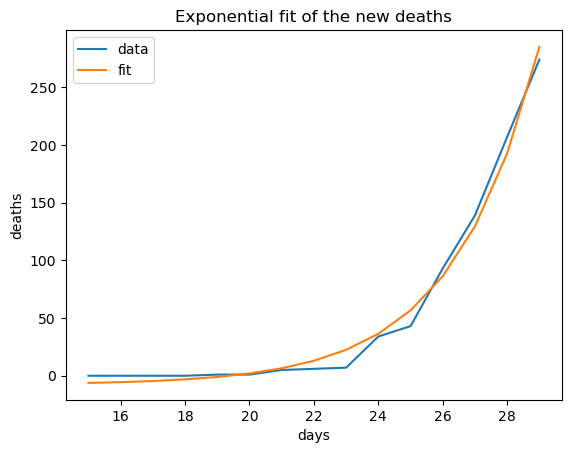

In [271]:
min=15
max=30
interval=[i for i in range(min,max)]
p, cov =curve_fit(exponential_func, dates_of_pandemic[interval], new_deaths[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02], maxfev = 10000)
print(p)
plt.plot(dates_of_pandemic[interval], new_deaths[interval], label='data')
plt.plot(dates_of_pandemic[interval], exponential_func(dates_of_pandemic[interval], *p), label='fit')
plt.legend()
plt.xlabel('days')
plt.ylabel('deaths')
plt.title('Exponential fit of the new deaths')
plt.show()

In [273]:
def objective_function(data, theta, X): 
    return 0.5*np.sum((data-h(theta, X))**2)



def hessian_obj_function(data, theta, X): 
    d_theta=0.0001
    hessian=np.zeros((len(theta), len(theta)))
    for i in range(len(theta)): 
        for j in range(len(theta)):
            theta_plus_i=theta.copy()
            theta_plus_j=theta.copy()
            theta_plus_ij=theta.copy()
            theta_plus_i[i]+=d_theta
            theta_plus_j[j]+=d_theta
            theta_plus_ij[i]+=d_theta
            theta_plus_ij[j]+=d_theta
            hessian[i,j]=(objective_function(data, theta_plus_ij, X)-objective_function(data, theta_plus_i, X)-objective_function(data, theta_plus_j, X)+objective_function(data, theta, X))/(d_theta**2)
    return hessian


In [334]:

def f_for_delta_method(train_dates, data, interval): 
    theta, _ = curve_fit(exponential_func, train_dates[interval], data[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02], maxfev = 10000)
    return theta

def grad_f_for_delta_method(train_dates, data, interval): 
    d_n=0.1
    grad=np.zeros(( len(data), 3) )
    for i in range(len(data)): 
        data_plus=data.copy()
        data_plus[i]+=d_n
        grad[i]=(f_for_delta_method(train_dates, data, interval)-f_for_delta_method(train_dates, data, interval))/d_n
    return grad


In [339]:
class ExponentialRegression(Model): 
    def train(self, train_dates, data):
        self.data=data
        self.train_dates=train_dates
        min=len(data)-15
        max=len(data)-1
        interval=[i for i in range(min,max)]
        self.interval=interval
        self.p, self.cov =curve_fit(exponential_func, train_dates[interval], data[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02], maxfev = 10000)
        self.trained=True


    def predict(self, reach, alpha, method='covariance'):
        assert self.trained, 'The model has not been trained yet'
        a=self.p[0]
        b=self.p[1]
        c=self.p[2]
        window_prediction=np.array([i for i in range(len(self.train_dates), len(self.train_dates) + reach )])
      
        prediction=exponential_func(window_prediction,a,b,c)

        if method == 'covariance': # we implemented four methods to compute the confidence intervals
            print('covariance method')
            perr = np.sqrt(np.diag(self.cov))
            self.perr=perr
        elif method == 'estimate_sigma': 
            print('estimate sigma')
            sigma2=estimate_sigma2(self.data[self.interval], exponential_func(self.train_dates[self.interval], *self.p), 3)
            A=compute_A(self.p, self.train_dates[self.interval])
            cov=sigma2*np.linalg.inv(np.matmul(A.transpose(), A))/len(self.interval)
            perr=np.sqrt(np.diag(cov))
            self.perr=perr
        elif method == 'hessian':
            print('hessian')
            hessian=hessian_obj_function(self.data[self.interval], self.p, self.train_dates[self.interval])
            self.hess=hessian
            cov=np.linalg.inv(hessian)
            perr=np.sqrt(abs(np.diag(cov)))
            self.perr=perr
        elif method == 'delta': 
            sigma2=estimate_sigma2(self.data[self.interval], exponential_func(self.train_dates[self.interval], *self.p), 3) * np.identity(len(self.data))
            grad=grad_f_for_delta_method(self.train_dates, self.data, self.interval)
            perr = np.sqrt(np.diag(np.matmul(np.matmul(grad.transpose(), sigma2) , grad)))
            self.perr = perr
            

        intervals=[prediction]
        a_sampled=[]
        b_sampled=[]
        c_sampled=[]
        for i in range(100): 
            a_r= np.random.normal(self.p[0], perr[0], 1)[0]
            b_r=np.random.normal(self.p[1], perr[1], 1)[0]
            c_r=np.random.normal(self.p[2], perr[2], 1)[0]
            a_sampled.append(a_r)
            b_sampled.append(b_r)
            c_sampled.append(c_r)
            prediction_sampled=exponential_func(window_prediction,a_r, b_r,c_r)
            intervals.append(prediction_sampled)
        self.a_sampled=a_sampled
        self.b_sampled=b_sampled
        self.c_sampled=c_sampled
        intervals=np.array(intervals).transpose()
        self.intervals=intervals
        ci_low=np.array([np.quantile(intervals[i], alpha/2) for i in range(reach)])
        ci_high=np.array([np.quantile(intervals[i],1-alpha/2) for i in range(reach)])
        return prediction, [ci_low, ci_high]




We test the model to make predictions 7 days ahead. It explodes as the exponential function is very sensitive to slight variations of the parameters. 

In [342]:
mymodel.perr

array([5.05703021e-04, 2.77118447e-02, 2.66708162e+00])

covariance method


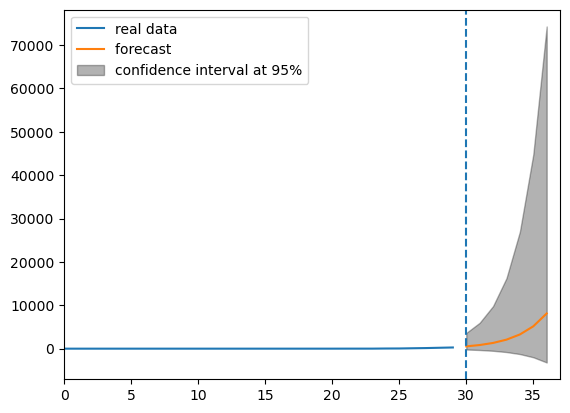

In [340]:
mymodel=ExponentialRegression()
%matplotlib inline
mymodel.train(dates_of_pandemic[:30], new_deaths[:30])

mymodel.plot(7, 0.05)

Meanwhile, the confidence interval is not very high on the train set: 

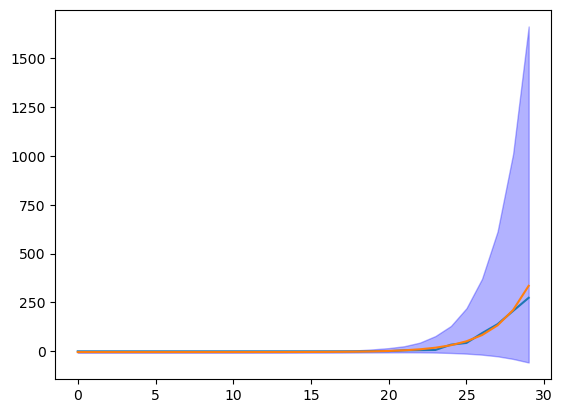

In [265]:
plt.plot(dates_of_pandemic[:30], new_deaths[:30])
plt.plot(dates_of_pandemic[:30], exponential_func(dates_of_pandemic[:30], *mymodel.p))
a_sampled=mymodel.a_sampled
b_sampled=mymodel.b_sampled
c_sampled=mymodel.c_sampled
intervals=[]
for i in range(len(a_sampled)):
    func=exponential_func(dates_of_pandemic[:30], a_sampled[i], b_sampled[i], c_sampled[i])
    intervals.append(func)
intervals=np.array(intervals).transpose()
ci_low=np.array([np.quantile(intervals[i], 0.05) for i in range(30)])
ci_high=np.array([np.quantile(intervals[i],0.95) for i in range(30)])
plt.fill_between(dates_of_pandemic[:30], ci_low, ci_high, color='b', alpha=0.3)
plt.show()

